# Introduction

### Objective(s)
    Develop a Data Masking Machine Learning Algorithm that makes it hard to recover a customer's personal information within the Sure Tomorrow insurance company.

### Goal(s)
    Evaluate and showcase findings for the four tasks provided by the company that's listed below.

### Questions(s)
 * Can we find customers who are similar to a given customer? This will help the company's agents with marketing.
 * Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
 * Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
 * Protect clients' personal data without breaking the model from the previous task.

## Initialization

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics  import f1_score, mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
#Load Data Here

df = pd.read_csv('/datasets/insurance_us.csv')

# Data Preprocessing & Exploration

In [3]:
df

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
787,1,26.0,41100.0,1,0
1076,0,33.0,44000.0,2,0
4253,0,20.0,32000.0,2,0
4386,1,32.0,30600.0,1,0
1627,1,41.0,34300.0,2,0
4920,0,23.0,51300.0,1,0
3808,1,23.0,33600.0,2,0
4813,1,20.0,32000.0,0,0
3117,0,60.0,43400.0,2,4
2272,0,30.0,42800.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:

In [8]:
df['age'] = df['age'].astype(int)

In [9]:
# check to see that the conversion was successful

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [11]:
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [12]:
df.duplicated().sum()

153

In [13]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [14]:
df['age'].describe()

count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: age, dtype: float64

The maximum, minimum, and average age found admist the data, respectively is: 65, 18, and 30; although most of the age demographic is around their late 30s.

In [15]:
df['income'].describe()

count     5000.000000
mean     39916.360000
std       9900.083569
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: income, dtype: float64

The average income for a customer is pretty close to 40k (which is in the ball park range for most customers as they make about 46.6k) and the highest and lowest recorded income respectively lies at 79,000 to 5,300.

In [16]:
df['family_members'].describe()

count    5000.000000
mean        1.194200
std         1.091387
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: family_members, dtype: float64

Max insured family members is 6, loweset being only one additional loved one. On average and compartively to 75% of the pooling demographic, there's only 1 or 2 additional members being added onto the insurance plan, respectively.

In [17]:
df['insurance_benefits'].describe()

count    5000.000000
mean        0.148000
std         0.463183
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: insurance_benefits, dtype: float64

In [18]:
df['insurance_benefits'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

In relation to insurance benefits, the max someone receives is 5 and 0 being the least; however, this seems pretty typically when it comes to insurance plans cause you normally are proactively paying for coverage *within the case if something does happen*. For example, about 88% (4436/5000) of customers had no benefit payout, and 423 customers had received one form of benefit payout which accounts for 8.46%. So if a customer were to receive any benefits, that means there was some form of misfortune involved and if no benefits are received then we can assume no misfortune occured. 

So maybe, if we were to throw out a generalize ballpark assumption about our "typical, average" customer profile we could say..

* Based on our data, the typical customer reflects a 30 something-yr-old who makes 39-40k anually in income, usually insures another indidviual outside themselves and are more prone to not needing any benefit payouts as their life isn't met with consistent misfortune.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

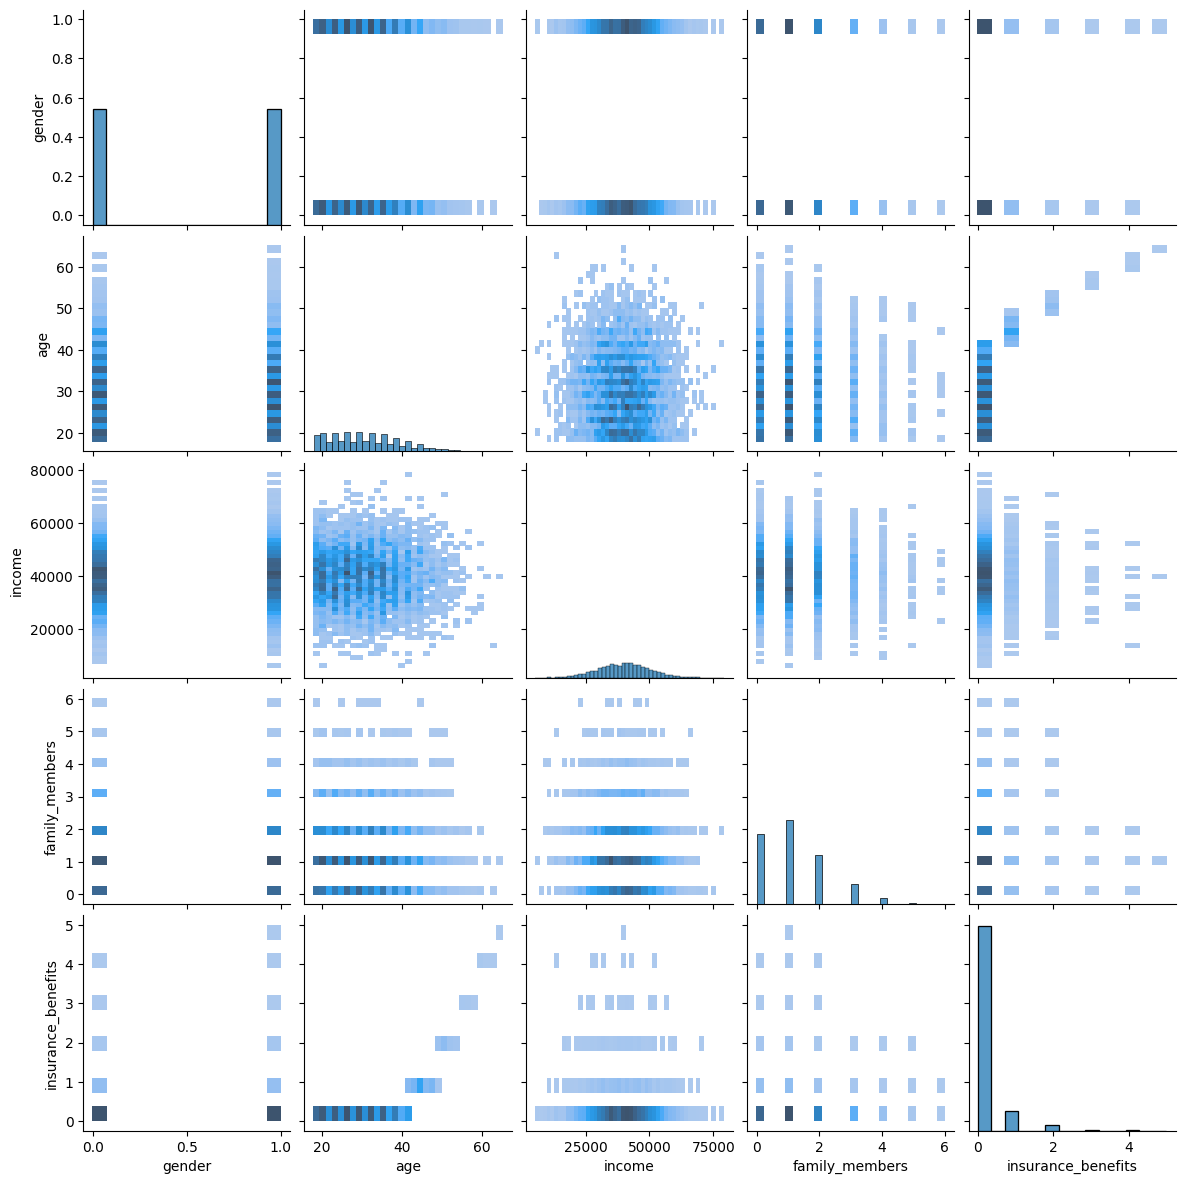

In [19]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (or the nearest objects) for a given object, based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [21]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: our insurance dataset
    :param n: the specific item/thing you want to find other similiar items to
    :param k: the amount of closest neighbours that is returned
    :param metric: the distance metric's name that's being used
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_distance = pd.concat([df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_distance

Scaling the data.

In [22]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [23]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4919,1.0,0.523077,0.613924,0.500000,0
2894,0.0,0.338462,0.745570,0.666667,0
3314,1.0,0.369231,0.594937,0.166667,0
256,0.0,0.876923,0.355696,0.333333,3
3435,1.0,0.461538,0.515190,0.166667,0


Now, let's get similar records for a given one for every combination

### No Scale Distances

In [24]:
ed_noscale = get_knn(df, n=0, k=5, metric='euclidean')
print("Euclidean Distance with no scale data:\n \n", ed_noscale)

Euclidean Distance with no scale data:
 
       gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625


In [25]:
md_noscale = get_knn(df, n=0, k=5, metric='manhattan')
print("Manhattan Distance with no scaled data:\n \n", md_noscale)

Manhattan Distance with no scaled data:
 
       gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
3424       0   38  49600.0               0                   0       5.0


### Scaled Distances


In [26]:
ed_scaled = get_knn(df_scaled, n=0, k=5, metric='euclidean')
print("Euclidean Distance with scaled data:\n \n", ed_scaled)

Euclidean Distance with scaled data:
 
       gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550


In [27]:
md_scaled = get_knn(df_scaled, n=0, k=5, metric='manhattan')
print("Manhattan Distance with scaled data:\n \n", md_scaled)

Manhattan Distance with scaled data:
 
       gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?**

I believe the data not being scaled will affect the KNN algorithm cause of the fact that all features don't have the same weight or measurement so things like age and income will drastically alter the distance metric's calculation, incorrectly.

In [28]:
ed_nos = ed_noscale.to_numpy()
md_nos = md_noscale.to_numpy()

print("np.allclose:", np.allclose(ed_nos, md_nos))
print("np.array_equal:", np.array_equal(ed_nos, md_nos))

np.allclose: False
np.array_equal: False


**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

I think both resulting dataframes are not quite similar at all, and although regardless of the scaling, I believe the scaled calculations probably improved or increased a fair chance for all of the features to be weighted the same during calculation, compared to the non-scaled dataframe.

In [29]:
md_scaled = md_scaled.to_numpy()
md_nos = md_noscale.to_numpy()

print("np.allclose:", np.allclose(md_scaled, md_nos))
print("np.array_equal:", np.array_equal(md_scaled, md_nos))

np.allclose: False
np.array_equal: False


# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [30]:
df['insurance_benefits_received'] =  df['insurance_benefits'].apply(lambda x: 1 if x > 0 else 0)
#total number of clients
total_customers = len(df)

customers_insured = df['insurance_benefits_received'].sum()
insured_probability = customers_insured / total_customers

In [31]:
insured_probability

0.1128

In [32]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [33]:
feature = df[['gender', 'age', 'income', 'family_members']]
target = df[['insurance_benefits_received']]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=12034)

In [35]:
print('Train Features Shape:', x_train.shape)
print('Train Target Shape:', y_train.shape)
print('Test Features Shape:', x_test.shape)
print('Test Target Shape:', y_test.shape)

Train Features Shape: (3500, 4)
Train Target Shape: (3500, 1)
Test Features Shape: (1500, 4)
Test Target Shape: (1500, 1)


In [36]:
# the variable's value is hard-coded into the dummy classifier's probabilities 
y_train.mean()

insurance_benefits_received    0.112857
dtype: float64

In [37]:
#scaling the data
scaler = MaxAbsScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [38]:
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"K={k}, F1 Score (Original Data): {f1}")

    knn.fit(x_train_scaled, y_train)
    y_pred_scaled = knn.predict(x_test_scaled)
    f1_scaled = f1_score(y_test, y_pred_scaled, average='macro')
    print(f"K={k}, F1 Score (Scaled Data): {f1_scaled}")

K=1, F1 Score (Original Data): 0.8046158893112831


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=1, F1 Score (Scaled Data): 0.9865937365937366
K=2, F1 Score (Original Data): 0.6687694905722424


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=2, F1 Score (Scaled Data): 0.9666759818015782
K=3, F1 Score (Original Data): 0.6896658735905659
K=3, F1 Score (Scaled Data): 0.9794618080911348


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=4, F1 Score (Original Data): 0.5392395579696572
K=4, F1 Score (Scaled Data): 0.9648248983439562
K=5, F1 Score (Original Data): 0.5425854758948057


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=5, F1 Score (Scaled Data): 0.9611535044605911
K=6, F1 Score (Original Data): 0.5203518979246445


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=6, F1 Score (Scaled Data): 0.9631681904122706
K=7, F1 Score (Original Data): 0.5223824686270837
K=7, F1 Score (Scaled Data): 0.9693564862104189


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=8, F1 Score (Original Data): 0.49203796743894057
K=8, F1 Score (Scaled Data): 0.9577898780127474
K=9, F1 Score (Original Data): 0.4914148075705698


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K=9, F1 Score (Scaled Data): 0.9623466481670806
K=10, F1 Score (Original Data): 0.4816703505217035
K=10, F1 Score (Scaled Data): 0.9577898780127474


In [39]:
# Dummy classifier with different probabilities    
probabilities = [0, 0.112857, 0.5, 1]
for prob in probabilities:
    if prob == 0:
        dummy = DummyClassifier(strategy='constant', constant=0)
    elif prob == 1:
        dummy = DummyClassifier(strategy='constant', constant=1)
    else:
        dummy = DummyClassifier(strategy='stratified')

    dummy.fit(x_train, y_train)
    y_pred_dummy = dummy.predict(x_test)
    f1_dummy = f1_score(y_test, y_pred_dummy, average='macro')
    print(f"Dummy Model with Probability {prob}, F1 Score: {f1_dummy}")

Dummy Model with Probability 0, F1 Score: 0.47015188979159306
Dummy Model with Probability 0.112857, F1 Score: 0.5028941096356827
Dummy Model with Probability 0.5, F1 Score: 0.4995689237682639
Dummy Model with Probability 1, F1 Score: 0.10125823846614738


# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [40]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'RMSE w/o format: {rmse}')
    print(f'R2 Value: {r2}')

In [41]:
x = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12034)

lr = MyLinearRegression()

lr.fit(x_train, y_train)
print('OG Data\'s Weights:', lr.weights, '\n')
y_test_pred = lr.predict(x_test)

eval_regressor(y_test, y_test_pred)

OG Data's Weights: [-9.12703098e-01  3.55040354e-02  4.67988600e-03 -6.55055779e-07
 -1.14714139e-02] 

RMSE: 0.36
RMSE w/o format: 0.3559296692823234
R2 Value: 0.4236891602917424


In [42]:
scaler = MaxAbsScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [43]:
lr.fit(x_train_scaled, y_train)
print('Scaled Data\'s Weights:', lr.weights, '\n')
y_test_pred_scaled = lr.predict(x_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

Scaled Data's Weights: [-0.9127031   2.20125019  0.00467989 -0.05174941 -0.06882848] 

RMSE: 0.36
RMSE w/o format: 0.3559296692823231
R2 Value: 0.4236891602917433


**Can you see any difference in RMSE between these two cases?**

There is *a difference* but hardly sigificant to call it an actual notable difference; so really, no I can't lol.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [44]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [45]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [46]:
rndm_matrix = np.random.default_rng(seed=120)
P = rndm_matrix.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [47]:
if np.linalg.det(P) == 0:
    raise ValueError("Matrix P is not invertible")

**Can you guess the customers' ages or income after the transformation?**

After printing out the *X_prime* variable to see, no I can't actually.

In [48]:
X_prime = X @ P

In [49]:
X_prime

array([[48604.77253266, 31999.75973883,  1644.13776906, 23420.76536337],
       [37245.38244438, 24524.15456017,  1267.48559393, 17948.35559147],
       [20584.85105112, 13554.72797957,   702.08738266,  9919.96442679],
       ...,
       [33215.03128291, 21866.50804694,  1119.92266611, 16004.37157348],
       [32042.06647861, 21094.26185582,  1082.60116236, 15439.89570506],
       [39782.36338076, 26190.26911559,  1342.93274778, 19169.1387983 ]])

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [50]:
P_inv = np.linalg.inv(P)
X_recovered = X_prime @ P_inv

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [51]:
print("Original Data:\n", X[:3])
print("Transformed Data:\n", X_prime[:3])
print("Recovered Data:\n", X_recovered[:3])

Original Data:
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]
Transformed Data:
 [[48604.77253266 31999.75973883  1644.13776906 23420.76536337]
 [37245.38244438 24524.15456017  1267.48559393 17948.35559147]
 [20584.85105112 13554.72797957   702.08738266  9919.96442679]]
Recovered Data:
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-1.07947933e-10  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.40688756e-11  2.90000000e+01  2.10000000e+04 -4.63266828e-11]]


**You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?**

Since I know what P is (as I'm working with the data first-handedly), I can recover X or the original data..but honestly, I don't think I would be able to dechiper what X **could be** if I only seen the transformed data.

Although despite the cell box below where I tried finding a way to compare the two to see if the reverted data is close to the original. I think during the transforming-to-reversing phase of the data, there were a few errors that had occured where maybe I need to revisit and improve the algorithm to minimize or completely avoid them all together by maybe rounding (?) cause in 2 instances, for example, we have *-4.47363596e-12* and *9.52452315e-13* show up in the reverse data when originally those 2 instances shouldve reverted back to **0.00e+00**.

But on the other hand, I think this normal to see a few tiny measures of error during calculations and also that, this'll make it challanging to figure out the true data for anyone who shouldn't have it in their hands.

In [52]:
# Check if the recovered data is the same as the original data
print("T/F - The recovered data is close to the original data:")
print(np.allclose(X, X_recovered)) #save np.allclose this is a good tip to compare floating numbers

T/F - The recovered data is close to the original data:
True


## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer + Analytical proof**

Put simply, I think the linkage between $w$ & $w_P$ is easier to see when they are boiled down to their simpliest form of expression. Given that, when you apply the data mask during the matrix multiplication, the resulting matrix doesn't affect the Linear Regressions' performance when making predicitions as the predicted values and their RMSE will remain the same. Although...

Imma try my best to explain this analytically here but I believe *w* & **wp** is linked through simplfying the expression more like this:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y ⇒ wP= [(P T X T )(XP)] −1 (P T X T)y
$$
as this should reduce themselves where you take the matrix inversion respectively on both sides and you be able to get something like this 😭😭?
$$ w P =P −1 (X T X) −1 (P T ) −1 P T X T y$$

now that the above expression is reduced to its current state, it shows its similarity (in terms of the wp & w being related) to the original: 
$$
w = (X^T X)^{-1} X^T y
$$

Therefore, from our denoted symbols stated from earlier:

- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector
- $y = Xw$


When using the obfuscated weight $w_P$ ( $\hat{y}_P = Xw$ ) & the original weights $w$ ( $\hat{y}= Xw$ ) during predictions we understand that $\hat{y}_P$ which is using the masked data is practically the same as the $\hat{y}$ that's using the original data.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [53]:
#random matrix P
random_mtrx = np.random.default_rng(seed=12054)
P = random_mtrx.random(size=(X.shape[1], X.shape[1]))

# training the obfuscate data
X_train_obfuscated = x_train @ P
X_test_obfuscated = x_test @ P

In [54]:
#normal data trained & tested
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_original = lr.predict(x_test)
print("Original Data Predictions:")
eval_regressor(y_test, y_pred_original)

#obfuscated data trained & tested
lr.fit(X_train_obfuscated, y_train)
y_pred_obfuscated = lr.predict(X_test_obfuscated)
print("\n""Obfuscated Data Predictions:")
eval_regressor(y_test, y_pred_obfuscated)

Original Data Predictions:
RMSE: 0.36
RMSE w/o format: 0.3559296692823235
R2 Value: 0.4236891602917421

Obfuscated Data Predictions:
RMSE: 0.36
RMSE w/o format: 0.35592966928231423
R2 Value: 0.42368916029177206


In [55]:
# Compare the predicted values
print("Original data's predictions:\n", y_pred_original, "\n")
print("Obfuscated data's predictions:\n", y_pred_obfuscated)

Original data's predictions:
 [ 0.73958637  0.34061556 -0.11515136 ...  0.29157292 -0.24543406
  0.20183818] 

Obfuscated data's predictions:
 [ 0.73958637  0.34061556 -0.11515136 ...  0.29157292 -0.24543406
  0.20183818]


In [56]:
print("T/F - The Obfuscated & Original datas' predictions are close if not similar:")
print(np.allclose(y_pred_original, y_pred_obfuscated))

T/F - The Obfuscated & Original datas' predictions are close if not similar:
True


# Conclusions

In order to ensure our clients' personal data doesn't fall into the wrong hands, we developed a data masking machine learning algorithm that incorporates and tests out a randomized matrix that encrypts the original data while avoiding any (notable) alteration to the data's prior integrity. Furthermore, explore four tasks that predict a Sure Tomorrow customer's probability in receiving benefits and whether they share any mutual characteristics with other customers for marketing purposes.


In short, we have successfully created a data-masking algorithm that conceals customers information while also avoiding the data becoming unimpaired when we manipulate the data from one state to the other. As for the presented tasks, we were also capable of finding customers related to others as the best 'K-Level' (out of 10) iteration(s) was **K-1** in terms of both the original and scaled data's high accuracy. For the 8th k-level iteration and beyond, relatively, each's original data did not do so well (comparing to the dummy model) even though their scaled data was doing well in terms of accuracy as the scaled data clearly outshined the dummy model's performance.


In terms of predicting a customer's chances of receiving insurance benefits, based on the actual data, there's about a 11% acceptance rate with about 550-565 out of 5,000 customers who has gotten benefits.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>